In this notebook, we will discuss a more fine-grained way of examining a signal in the frequency domain that accounts for the fact that a signal can change over time.

# Important: Run this code cell each time you start a new session!

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install os
!pip install librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import Audio
import librosa as lr
import librosa.display

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [2]:
!wget -Ncnp https://physionet.org/files/accelerometry-walk-climb-drive/1.0.0/raw_accelerometry_data/id00b70b13.csv

--2024-06-21 03:40:06--  https://physionet.org/files/accelerometry-walk-climb-drive/1.0.0/raw_accelerometry_data/id00b70b13.csv
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25931775 (25M) [text/plain]
Saving to: ‘id00b70b13.csv’

id00b70b13.csv      100%[===================>]  24.73M   631KB/s    in 41s     

2024-06-21 03:40:47 (620 KB/s) - ‘id00b70b13.csv’ saved [25931775/25931775]



In [3]:
df = pd.read_csv('id00b70b13.csv')

# Filter to only walking activity, which is given a code of 1
df = df[df['activity'] == 1]

# Process the time
df.rename(columns={'time_s': 'Time'}, inplace=True)
df = df[(df['Time']>=700) & (df['Time']<=710)]
df['Time'] = df['Time'] - df['Time'].min()

# Process the accel
df['Accel'] = np.sqrt(df['la_x']**2 + df['la_y']**2 + df['la_z']**2)*9.8

# Keep only crucial columns
keep_cols = ['Time', 'Accel']
df = df[keep_cols]
df.to_csv('walking.csv',index=False)

<ipython-input-3-56954139a89d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time'] = df['Time'] - df['Time'].min()
<ipython-input-3-56954139a89d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Accel'] = np.sqrt(df['la_x']**2 + df['la_y']**2 + df['la_z']**2)*9.8


In [4]:
!wget -Ncnp https://physionet.org/files/sufhsdb/1.0.1/f1.wav

--2024-06-21 03:40:48--  https://physionet.org/files/sufhsdb/1.0.1/f1.wav
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2432684 (2.3M) [text/plain]
Saving to: ‘f1.wav’

f1.wav              100%[===================>]   2.32M   623KB/s    in 3.8s    

2024-06-21 03:40:52 (623 KB/s) - ‘f1.wav’ saved [2432684/2432684]



In [5]:
os.rename('f1.wav', 'heart_sound.wav')

# Spectrograms

A ***spectrogram*** is a visual representation of the frequency content of a signal over time. It is generated by using the ***short-time Fourier Transform (STFT)***, which involves the following steps:
1. The time-domain signal is divided into overlapping windows
2. An FFT is calculated for each window
3. Since a given period of time may be included in multiple windows, the FFT results for that period are calculated by merging the results across those windows (e.g., weighted average)
4. The results are plotted such that the vertical axis represents frequency, the horizontal axis represents time, and the color/brightness of the pixels indicates the magnitude of the frequency components over time

There are a few different ways you can think about a spectrogram:
* As a heatmap that illustrates the frequency content over time
* As a sequence of FFTs over time,
* As a 2D array where each row corresponds to a frequency, each column corresponds to a time, and the value at that position corresponds to the amount of frequency content at that frequency and time
* As a table with three columns: time, frequency, and amount of frequency content at that frequency at that time.

The point is that while we often view spectrograms as heatmaps, these heatmaps are simply showing numbers that we can use to summarize our signals.

Let's write some functions to generate waveforms and visualize their spectrograms:

In [6]:
def generate_sinusoid(freqs, amps, fs=1000):
    """
    Computes a linear combination of sinusoids with various frequencies and amplitudes
    freqs: a list of frequencies
    amps: a list of amplitudes
    fs: the sampling rate of our signal
    """
    x = np.arange(0, 100, 1.0/fs)
    y = 0
    for freq, amp in zip(freqs, amps):
        y += amp*np.sin(2*np.pi*freq*x)
    return x, y

In [7]:
from scipy import signal
def show_spectrogram(x, y, fs=1000, win_len=1, win_percent_overlap=12.5,
                     time_ylim=None, fft_xlim_max=None):
    """
    Shows the time-domain signal and the corresponding spectrogram
    x: the timestamps of the signal as a Numpy array
    y: the values of the signal as a Numpy array
    fs: the sampling rate of our signal
    win_len: the length of the window in seconds
    win_percent_overlap: the percentage of overlap between consecutive windows
    time_ylim: the boundaries of the y-axis for the time-domain plot
    fft_xlim_max: the top boundary for the y-axis of the spectrogram,
    indicating the highest frequency we care to view
    """
    # Compute the window parameters
    num_window_points_len = int(fs*win_len)
    num_window_points_overlap = int(num_window_points_len*(win_percent_overlap/100))

    # Compute the spectrogram
    freqs, times, spectro = signal.spectrogram(y, fs,
                                               nperseg=num_window_points_len,
                                               noverlap=num_window_points_overlap)

     # Show the signal in the time domain
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    plt.plot(x, y)
    plt.xlabel('Time (s)')
    plt.ylabel('Value')
    if time_ylim:
        plt.ylim(time_ylim[0], time_ylim[1])
    plt.title('Time Domain')

    # Show the signal in the frequency domain
    plt.subplot(1, 2, 2)
    plt.pcolormesh(times, freqs, spectro, shading='gouraud')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.ylim(-0.1, fft_xlim_max if fft_xlim_max else freqs.max())
    plt.title('Frequency Domain')
    plt.show()

Play around with the examples below to see how the spectrogram is able to show us the frequency content over time for simple signals. We've changed the range of frequencies that can be tested to avoid some complicated nuances beyond the scope of this lecture:

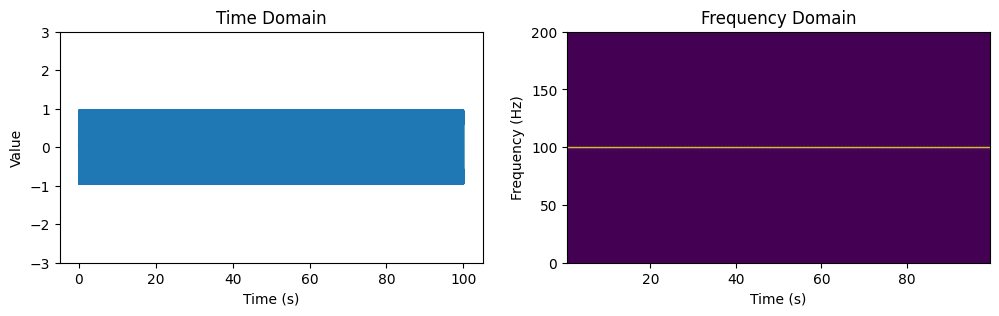

In [8]:
freq = 100 #@param {type:"slider", min:50, max:150, step:50}
amp = 1 #@param {type:"slider", min:0.5, max:1.5, step:0.5}
x, y = generate_sinusoid([freq], [amp])
show_spectrogram(x, y, time_ylim=[-3, 3], fft_xlim_max=200)

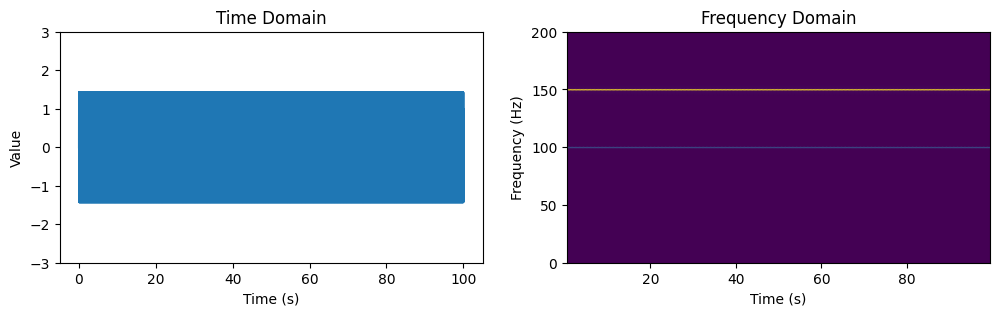

In [9]:
freq1 = 150 #@param {type:"slider", min:50, max:150, step:50}
freq2 = 100 #@param {type:"slider", min:50, max:150, step:50}
amp1 = 1 #@param {type:"slider", min:0.5, max:1.5, step:0.5}
amp2 = 0.5 #@param {type:"slider", min:0.5, max:1.5, step:0.5}
x, y = generate_sinusoid([freq1, freq2], [amp1, amp2])
show_spectrogram(x, y, time_ylim=[-3, 3], fft_xlim_max=200)

Here are some observations to be gathered from these examples:
* **Different horizontal axes:** Notice how the x-axes of both graphs look slightly different. This is because the spectrogram is only able to generate results when the entire window is full of data. When the window is centered around `t=0`, half of the window is empty and it cannot calculate the FFT for that part of the signal.
* **Horizontal bands:** Because the frequency of our signals do not change over time, the FFT for each sliding window remains the same. Therefore, the frequency content does not change over time and we see horizontal bands in the spectrogram.
* **Location of frequency content:** Analagous to our FFTs, the position of the horizontal bands is dictated by the frequency of the sinusoids that compose our overall signal. For example, a sinusoid at 50 Hz will have a horizontal band at 50 Hz in its spectrogram.
* **Relative intensity of the frequency content:** The brightness of the bands represents the strength of each frequency component. For example, if a signal has components at 100 Hz and at 150 Hz but the latter has twice the amplitude of the former, then the band at 150 Hz in the spectrogram will be twice as bright.

# Example 1: Step Counting with Motion Data

Let's generate the spectrogram of our walking motion data:

In [10]:
df = pd.read_csv('walking.csv')
x = df['Time'].values
y = df['Accel'].values
y -= y.mean()

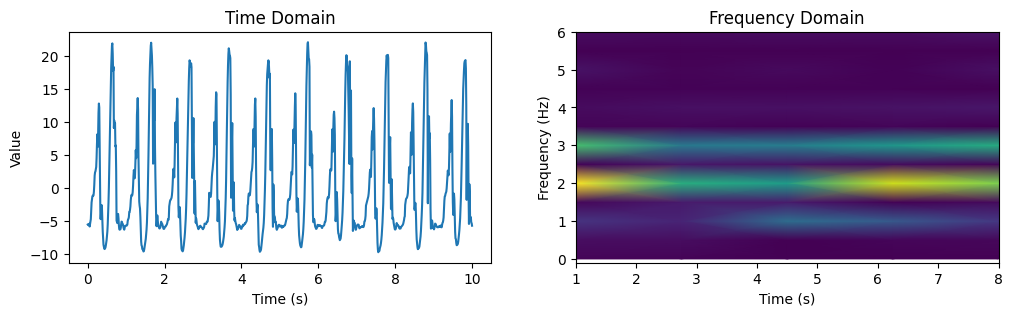

In [11]:
win_len = 2 #@param {type:"slider", min:0.5, max:3, step:0.5}
win_percent_overlap = 12.5 #@param {type:"slider", min:12.5, max:87.5, step:12.5}
show_spectrogram(x, y, fs=100, win_len=win_len,
                 win_percent_overlap=win_percent_overlap,
                 fft_xlim_max=6)

Before playing with the sliders, let's talk about what we see in our spectrogram:
* **Horizontal bands:** Like our simple sinusoids from earlier, the frequency content of this signal hardly changes over time because the person was walking at a fairly consistent pace. Therefore, we see horizontal bands in our spectrogram.
* **Location of the frequency content:** Recall that when we looked at the FFT of this signal, we saw a significant spike at 2 Hz, slightly lower spike at 1 Hz and 3 Hz, and then even lower peakspikes at other integer multiples of 1 Hz. We can observe similar trends in our spectrogram, only with horizontal bands rather than spike.
* **Slight changes in the horizontal bands:** If you look closely, you might notice that the horizontal bands change slightly in their slope and intensity over time. This could indicate that the person is gradually changing their pace over time.

Now try to play around with the sliders in order to change the parameters of the sliding window used to generate the spectrogram. Notice that when we use a shorter window, it's harder to see the bands that we saw earlier. This is because the algorithm "sees" less information when it uses a shorter window. If the window is not long enough to see two peaks per second, then it's hard for it to be confident that there are two steps per second.

# Example 2: Heart Sound Audio

Let's generate the spectrogram of our heart sound audio:

In [12]:
from scipy import signal
y, fs = librosa.load('heart_sound.wav', sr=16000, mono=True,
                     offset=25, duration=5)
time = np.arange(0, len(y))/fs

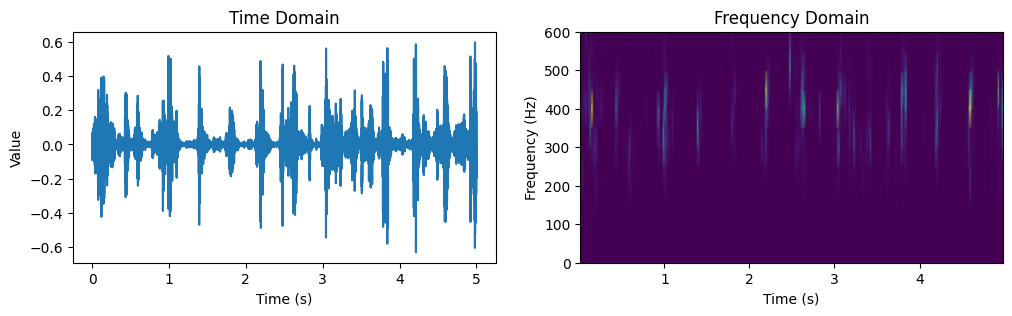

In [13]:
win_len = 0.02 #@param {type:"slider", min:0.005, max:1, step:0.05}
win_percent_overlap = 12.5 #@param {type:"slider", min:12.5, max:87.5, step:12.5}
show_spectrogram(time, y, fs=fs, win_len=win_len,
                 win_percent_overlap=win_percent_overlap,
                 fft_xlim_max=600)

Let's talk about why this spectrogram looks so different:
* **Horizontal position of frequency content:** Because the sounds start and stop over time, we see bursts of frequency content over time. It is important to note that the dark regions between these bursts do not necessarily imply that there is absolutely no frequency content at those times. Rather, this is an artefact of the heatmap's color scale.
* **Vertical position of the frequency content:** When we computed the FFT over the entire signal, we saw that the biggest spike was at roughly 480 Hz. Similarly, we can see that the bursts of frequency content are generally centered around 480 Hz. However, using a spectrogram allows us to see how the dominant frequency changes over time. For example, we see that the sounds generated at the beginning have a dominant frequency is roughly 400 Hz, whereas the later sounds become slightly higher pitched.
* **Magnitude of the frequency content**: Not only do we see that the frequency of the sounds change over time; we also see that the bursts change in intensity over time. The sounds in the first half of the signal were quieter than those in the second half, and we see that the bursts in the first half of the spectrogram are dimmer than those in the second half.
